1. kv1.3 itself made of protein amder dataset ta 
2. IC50

## Installation

In [ ]:
# # Install RDKit.
# %%capture
# !pip install rdkit-pypi

In [ ]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2021-11-28 14:08:27--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2021-11-28 14:08:27--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M   135MB/s    in 0.2s    

2021-11-28 14:08:27 (135 MB/s) - ‘padel.zip’ saved [25768637/25768637]

--2021-11-28 14:08:27--  https://github

In [ ]:
# ! pip install chembl_webresource_client

In [ ]:
# !pip install lazypredict

# Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

from sklearn.metrics import accuracy_score , confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lazypredict
from lazypredict.Supervised import LazyRegressor
from chembl_webresource_client.new_client import new_client as n_c

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

**Kv1. 3 channel blockers have been found to alleviate disease symptoms in animal autoimmune diseases, chronic inflammatory diseases, and metabolic disease models without obvious side effects (Perez-Verdaguer et al., 2016).**

In [ ]:
# Target search for KV1.3 Blockers
target = n_c.target
target_query = target.search('KCNA3') #KCNA3 is a gene
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P16390', 'xref_name': None, 'xre...",Mus musculus,Voltage-gated potassium channel subunit Kv1.3,14.00,False,CHEMBL4818,"[{'accession': 'P16390', 'component_descriptio...",SINGLE PROTEIN,10090
1,"[{'xref_id': 'P22001', 'xref_name': None, 'xre...",Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,12.00,False,CHEMBL4633,"[{'accession': 'P22001', 'component_descriptio...",SINGLE PROTEIN,9606
2,"[{'xref_id': 'P15384', 'xref_name': None, 'xre...",Rattus norvegicus,Voltage-gated potassium channel subunit Kv1.3,12.00,False,CHEMBL4248,"[{'accession': 'P15384', 'component_descriptio...",SINGLE PROTEIN,10116
3,[],Homo sapiens,Voltage-gated potassium channel,1.00,False,CHEMBL2362996,"[{'accession': 'P51787', 'component_descriptio...",PROTEIN FAMILY,9606


# *Select and retrieve bioactivity data for Homo sapiens  (2nd entry)* 

In [ ]:
selected_target = targets.target_chembl_id[1]
selected_target

'CHEMBL4633'

In [ ]:
activity = n_c.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [ ]:
# convert dictionary to pandas data frame
df = pd.DataFrame.from_dict(res)

In [ ]:
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,239620,[],CHEMBL819401,Displacement of [125I]- ChTX from human T cell...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CCCNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(Cl)cc1,None,None,CHEMBL1131887,Bioorg. Med. Chem. Lett.,1999,"{'bei': '12.73', 'le': '0.24', 'lle': '-1.45',...",CHEMBL421891,None,CHEMBL421891,5.01,False,http://www.openphacts.org/units/Nanomolar,208911,=,1,True,=,None,IC50,nM,None,9700.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,9.7
1,None,241014,[],CHEMBL819401,Displacement of [125I]- ChTX from human T cell...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CCCCNC(=O)c1cc(/C=C/c2ccccc2F)ccc1-c1ccc(Cl)cc1,None,None,CHEMBL1131887,Bioorg. Med. Chem. Lett.,1999,"{'bei': '12.49', 'le': '0.24', 'lle': '-1.75',...",CHEMBL111539,None,CHEMBL111539,5.10,False,http://www.openphacts.org/units/Nanomolar,208912,=,1,True,=,None,IC50,nM,None,8000.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,8.0
2,None,242254,[],CHEMBL819401,Displacement of [125I]- ChTX from human T cell...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC(C)NC(=O)c1cc(/C=C/c2ccc(Cl)c(F)c2)ccc1-c1cc...,None,None,CHEMBL1131887,Bioorg. Med. Chem. Lett.,1999,"{'bei': '12.68', 'le': '0.26', 'lle': '-1.68',...",CHEMBL109336,None,CHEMBL109336,5.43,False,http://www.openphacts.org/units/Nanomolar,208920,=,1,True,=,None,IC50,nM,None,3700.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,3.7
3,None,243680,[],CHEMBL819401,Displacement of [125I]- ChTX from human T cell...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CCNC(=O)c1cc(/C=C/CCc2ccccc2)ccc1-c1ccc(Cl)cc1,None,None,CHEMBL1131887,Bioorg. Med. Chem. Lett.,1999,"{'bei': '14.09', 'le': '0.27', 'lle': '-0.91',...",CHEMBL418444,None,CHEMBL418444,5.50,False,http://www.openphacts.org/units/Nanomolar,208919,=,1,True,=,None,IC50,nM,None,3200.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,3.2
4,None,243681,[],CHEMBL819401,Displacement of [125I]- ChTX from human T cell...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,N=C(N)NNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(...,None,None,CHEMBL1131887,Bioorg. Med. Chem. Lett.,1999,"{'bei': '13.23', 'le': '0.25', 'lle': '0.97', ...",CHEMBL109739,None,CHEMBL109739,5.41,False,http://www.openphacts.org/units/Nanomolar,208917,=,1,True,=,None,IC50,nM,None,3900.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,None,18519019,[],CHEMBL4193569,Inhibition of human Kv1.3 expressed in CHO cel...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,Nc1nc(CCCNC(=O)c2cc(Br)c(Br)[nH]2)c[nH]1,None,None,CHEMBL4190320,Eur J Med Chem,2017,None,CHEMBL4207090,None,CHEMBL4207090,None,False,http://www.openphacts.org/units/Nanomolar,3074923,>,1,True,>,None,IC50,nM,None,30000.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,30.0
885,None,18519020,[

In [ ]:
#Saved the pd database as CSV format
df.to_csv('KV1.3_01_bioactivity_data_raw.csv', index=False)

#2. Preprocess

### a. Handle missing **values**
*If* any compounds has missing value for the standard_value and canonical_smiles then that column is dropped .

In [ ]:
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,239620,[],CHEMBL819401,Displacement of [125I]- ChTX from human T cell...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CCCNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(Cl)cc1,None,None,CHEMBL1131887,Bioorg. Med. Chem. Lett.,1999,"{'bei': '12.73', 'le': '0.24', 'lle': '-1.45',...",CHEMBL421891,None,CHEMBL421891,5.01,False,http://www.openphacts.org/units/Nanomolar,208911,=,1,True,=,None,IC50,nM,None,9700.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,9.7
1,None,241014,[],CHEMBL819401,Displacement of [125I]- ChTX from human T cell...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CCCCNC(=O)c1cc(/C=C/c2ccccc2F)ccc1-c1ccc(Cl)cc1,None,None,CHEMBL1131887,Bioorg. Med. Chem. Lett.,1999,"{'bei': '12.49', 'le': '0.24', 'lle': '-1.75',...",CHEMBL111539,None,CHEMBL111539,5.10,False,http://www.openphacts.org/units/Nanomolar,208912,=,1,True,=,None,IC50,nM,None,8000.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,8.0
2,None,242254,[],CHEMBL819401,Displacement of [125I]- ChTX from human T cell...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC(C)NC(=O)c1cc(/C=C/c2ccc(Cl)c(F)c2)ccc1-c1cc...,None,None,CHEMBL1131887,Bioorg. Med. Chem. Lett.,1999,"{'bei': '12.68', 'le': '0.26', 'lle': '-1.68',...",CHEMBL109336,None,CHEMBL109336,5.43,False,http://www.openphacts.org/units/Nanomolar,208920,=,1,True,=,None,IC50,nM,None,3700.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,3.7
3,None,243680,[],CHEMBL819401,Displacement of [125I]- ChTX from human T cell...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CCNC(=O)c1cc(/C=C/CCc2ccccc2)ccc1-c1ccc(Cl)cc1,None,None,CHEMBL1131887,Bioorg. Med. Chem. Lett.,1999,"{'bei': '14.09', 'le': '0.27', 'lle': '-0.91',...",CHEMBL418444,None,CHEMBL418444,5.50,False,http://www.openphacts.org/units/Nanomolar,208919,=,1,True,=,None,IC50,nM,None,3200.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,3.2
4,None,243681,[],CHEMBL819401,Displacement of [125I]- ChTX from human T cell...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,N=C(N)NNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(...,None,None,CHEMBL1131887,Bioorg. Med. Chem. Lett.,1999,"{'bei': '13.23', 'le': '0.25', 'lle': '0.97', ...",CHEMBL109739,None,CHEMBL109739,5.41,False,http://www.openphacts.org/units/Nanomolar,208917,=,1,True,=,None,IC50,nM,None,3900.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,None,18519019,[],CHEMBL4193569,Inhibition of human Kv1.3 expressed in CHO cel...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,Nc1nc(CCCNC(=O)c2cc(Br)c(Br)[nH]2)c[nH]1,None,None,CHEMBL4190320,Eur J Med Chem,2017,None,CHEMBL4207090,None,CHEMBL4207090,None,False,http://www.openphacts.org/units/Nanomolar,3074923,>,1,True,>,None,IC50,nM,None,30000.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,30.0
885,None,18519020,[

*Here are we are considering Standard type = IC50 and the standard value means potency of the drug. Lower the number the better the potency of the drug becomes*


> 




we can also say lower potency means we need lower concentration of the drug 

In [ ]:
# checking the unique smiles values
len(df2.canonical_smiles.unique())

511

In [ ]:
# dropping the duplicates
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,239620,[],CHEMBL819401,Displacement of [125I]- ChTX from human T cell...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CCCNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(Cl)cc1,None,None,CHEMBL1131887,Bioorg. Med. Chem. Lett.,1999,"{'bei': '12.73', 'le': '0.24', 'lle': '-1.45',...",CHEMBL421891,None,CHEMBL421891,5.01,False,http://www.openphacts.org/units/Nanomolar,208911,=,1,True,=,None,IC50,nM,None,9700.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,9.7
1,None,241014,[],CHEMBL819401,Displacement of [125I]- ChTX from human T cell...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CCCCNC(=O)c1cc(/C=C/c2ccccc2F)ccc1-c1ccc(Cl)cc1,None,None,CHEMBL1131887,Bioorg. Med. Chem. Lett.,1999,"{'bei': '12.49', 'le': '0.24', 'lle': '-1.75',...",CHEMBL111539,None,CHEMBL111539,5.10,False,http://www.openphacts.org/units/Nanomolar,208912,=,1,True,=,None,IC50,nM,None,8000.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,8.0
2,None,242254,[],CHEMBL819401,Displacement of [125I]- ChTX from human T cell...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC(C)NC(=O)c1cc(/C=C/c2ccc(Cl)c(F)c2)ccc1-c1cc...,None,None,CHEMBL1131887,Bioorg. Med. Chem. Lett.,1999,"{'bei': '12.68', 'le': '0.26', 'lle': '-1.68',...",CHEMBL109336,None,CHEMBL109336,5.43,False,http://www.openphacts.org/units/Nanomolar,208920,=,1,True,=,None,IC50,nM,None,3700.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,3.7
3,None,243680,[],CHEMBL819401,Displacement of [125I]- ChTX from human T cell...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CCNC(=O)c1cc(/C=C/CCc2ccccc2)ccc1-c1ccc(Cl)cc1,None,None,CHEMBL1131887,Bioorg. Med. Chem. Lett.,1999,"{'bei': '14.09', 'le': '0.27', 'lle': '-0.91',...",CHEMBL418444,None,CHEMBL418444,5.50,False,http://www.openphacts.org/units/Nanomolar,208919,=,1,True,=,None,IC50,nM,None,3200.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,3.2
4,None,243681,[],CHEMBL819401,Displacement of [125I]- ChTX from human T cell...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,N=C(N)NNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(...,None,None,CHEMBL1131887,Bioorg. Med. Chem. Lett.,1999,"{'bei': '13.23', 'le': '0.25', 'lle': '0.97', ...",CHEMBL109739,None,CHEMBL109739,5.41,False,http://www.openphacts.org/units/Nanomolar,208917,=,1,True,=,None,IC50,nM,None,3900.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,None,18519018,[],CHEMBL4193569,Inhibition of human Kv1.3 expressed in CHO cel...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,Nc1nc(/C=C/CNC(=O)C2CCNCC2)c[nH]1,None,None,CHEMBL4190320,Eur J Med Chem,2017,None,CHEMBL4208681,None,CHEMBL4208681,None,False,http://www.openphacts.org/units/Nanomolar,3074922,>,1,True,>,None,IC50,nM,None,30000.0,CHEMBL4633,Homo sapiens,Voltage-gated potassium channel subunit Kv1.3,9606,None,None,IC50,uM,UO_0000065,None,30.0
884,None,18519019,[],CHEMB

#Data pre-processing of the bioactivity data


*Combine the 3 columns (molecule_chembl_id,canonical_smiles,standard_value) and bioactivity_class into a DataFrame*

In [ ]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL421891,CCCNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(Cl)cc1,9700.0
1,CHEMBL111539,CCCCNC(=O)c1cc(/C=C/c2ccccc2F)ccc1-c1ccc(Cl)cc1,8000.0
2,CHEMBL109336,CC(C)NC(=O)c1cc(/C=C/c2ccc(Cl)c(F)c2)ccc1-c1cc...,3700.0
3,CHEMBL418444,CCNC(=O)c1cc(/C=C/CCc2ccccc2)ccc1-c1ccc(Cl)cc1,3200.0
4,CHEMBL109739,N=C(N)NNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(...,3900.0
...,...,...,...
883,CHEMBL4208681,Nc1nc(/C=C/CNC(=O)C2CCNCC2)c[nH]1,30000.0
884,CHEMBL4207090,Nc1nc(CCCNC(=O)c2cc(Br)c(Br)[nH]2)c[nH]1,30000.0
885,CHEMBL4218820,Nc1nc(CCCNC(=O)c2cc3ccccc3[nH]2)c[nH]1,30000.0
886,CHEMBL4211453,Nc1nc(CCCNC(=O)C2Cc3ccccc3N2)c[nH]1,30000.0


In [ ]:
#Saves dataframe to CSV file
df3.to_csv('KV1.3_02_bioactivity_data_preprocessed.csv', index=False)

#Labeling compounds as either being active, inactive or intermediate

*The bioactivity data is in the IC50 unit. **Compounds having values of less than 1000 nM will be considered to be active** while those greater than 10,000 nM will be considered to be inactive. As for those values in between 1,000 and 10,000 nM will be referred to as intermediate*

In [ ]:
df4 = pd.read_csv('KV1.3_02_bioactivity_data_preprocessed.csv')


### Curation

In [ ]:
# based on the above mention threshold labeling is done
bioactivity_threshold = []
for i in df4.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

In [ ]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df5 = pd.concat([df4, bioactivity_class], axis=1)
df5

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL421891,CCCNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(Cl)cc1,9700.00,intermediate
1,CHEMBL111539,CCCCNC(=O)c1cc(/C=C/c2ccccc2F)ccc1-c1ccc(Cl)cc1,8000.00,intermediate
2,CHEMBL109336,CC(C)NC(=O)c1cc(/C=C/c2ccc(Cl)c(F)c2)ccc1-c1cc...,3700.00,intermediate
3,CHEMBL418444,CCNC(=O)c1cc(/C=C/CCc2ccccc2)ccc1-c1ccc(Cl)cc1,3200.00,intermediate
4,CHEMBL109739,N=C(N)NNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(...,3900.00,intermediate
...,...,...,...,...
506,CHEMBL4208681,Nc1nc(/C=C/CNC(=O)C2CCNCC2)c[nH]1,30000.00,inactive
507,CHEMBL4207090,Nc1nc(CCCNC(=O)c2cc(Br)c(Br)[nH]2)c[nH]1,30000.00,inactive
508,CHEMBL4218820,Nc1nc(CCCNC(=O)c2cc3ccccc3[nH]2)c[nH]1,30000.00,inactive
509,CHEMBL4211453,Nc1nc(CCCNC(=O)C2Cc3ccccc3N2)c[nH]1,30000.00,inactive


In [ ]:
#curated data is save as csv
df5.to_csv('KV1.3_03_bioactivity_data_curated.csv', index=False)

SAVING THE DATA on the local disc && ZIP the file

In [ ]:
! zip KV1_3.zip *.csv

  adding: KV1.3_01_bioactivity_data_raw.csv (deflated 95%)
  adding: KV1.3_02_bioactivity_data_preprocessed.csv (deflated 94%)
  adding: KV1.3_03_bioactivity_data_curated.csv (deflated 94%)


In [ ]:
! ls -l

total 26256
-rw-r--r-- 1 root root   785361 Nov 28 14:11 KV1.3_01_bioactivity_data_raw.csv
-rw-r--r-- 1 root root   128331 Nov 28 14:14 KV1.3_02_bioactivity_data_preprocessed.csv
-rw-r--r-- 1 root root   132888 Nov 28 14:16 KV1.3_03_bioactivity_data_curated.csv
-rw-r--r-- 1 root root    52797 Nov 28 14:16 KV1_3.zip
-rw-r--r-- 1 root root      231 Nov 28 14:08 padel.sh
-rw-r--r-- 1 root root 25768637 Nov 28 14:08 padel.zip
drwxr-xr-x 1 root root     4096 Nov 18 14:36 sample_data


In [ ]:
df_curated = pd.read_csv('KV1.3_03_bioactivity_data_curated.csv')
df_curated


,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL421891,CCCNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(Cl)cc1,9700.00,intermediate
1,CHEMBL111539,CCCCNC(=O)c1cc(/C=C/c2ccccc2F)ccc1-c1ccc(Cl)cc1,8000.00,intermediate
2,CHEMBL109336,CC(C)NC(=O)c1cc(/C=C/c2ccc(Cl)c(F)c2)ccc1-c1cc...,3700.00,intermediate
3,CHEMBL418444,CCNC(=O)c1cc(/C=C/CCc2ccccc2)ccc1-c1ccc(Cl)cc1,3200.00,intermediate
4,CHEMBL109739,N=C(N)NNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(...,3900.00,intermediate
...,...,...,...,...
506,CHEMBL4208681,Nc1nc(/C=C/CNC(=O)C2CCNCC2)c[nH]1,30000.00,inactive
507,CHEMBL4207090,Nc1nc(CCCNC(=O)c2cc(Br)c(Br)[nH]2)c[nH]1,30000.00,inactive
508,CHEMBL4218820,Nc1nc(CCCNC(=O)c2cc3ccccc3[nH]2)c[nH]1,30000.00,inactive
509,CHEMBL4211453,Nc1nc(CCCNC(=O)C2Cc3ccccc3N2)c[nH]1,30000.00,inactive


In [ ]:
df_curated_no_smiles = df_curated.drop(columns='canonical_smiles')

In [ ]:
smiles = []

for i in df_curated.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [ ]:
df_clean_smiles = pd.concat([df_curated_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL421891,9700.00,intermediate,CCCNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(Cl)cc1
1,CHEMBL111539,8000.00,intermediate,CCCCNC(=O)c1cc(/C=C/c2ccccc2F)ccc1-c1ccc(Cl)cc1
2,CHEMBL109336,3700.00,intermediate,CC(C)NC(=O)c1cc(/C=C/c2ccc(Cl)c(F)c2)ccc1-c1cc...
3,CHEMBL418444,3200.00,intermediate,CCNC(=O)c1cc(/C=C/CCc2ccccc2)ccc1-c1ccc(Cl)cc1
4,CHEMBL109739,3900.00,intermediate,N=C(N)NNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(...
...,...,...,...,...
506,CHEMBL4208681,30000.00,inactive,Nc1nc(/C=C/CNC(=O)C2CCNCC2)c[nH]1
507,CHEMBL4207090,30000.00,inactive,Nc1nc(CCCNC(=O)c2cc(Br)c(Br)[nH]2)c[nH]1
508,CHEMBL4218820,30000.00,inactive,Nc1nc(CCCNC(=O)c2cc3ccccc3[nH]2)c[nH]1
509,CHEMBL4211453,30000.00,inactive,Nc1nc(CCCNC(=O)C2Cc3ccccc3N2)c[nH]1


# Calculate Lipinski descriptors


Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:



*  Molecular weight < 500 Dalton
*  Octanol-water partition coefficient (LogP) < 5
*  Hydrogen bond donors < 5
*  Hydrogen bond acceptors < 10
>
Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation


In [ ]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,393.89,6.46,1.00,1.00
1,407.92,6.85,1.00,1.00
2,428.33,7.11,1.00,1.00
3,389.93,6.40,1.00,1.00
4,408.86,4.44,4.00,2.00
...,...,...,...,...
506,249.32,0.12,4.00,4.00
507,391.07,2.21,4.00,3.00
508,283.33,1.84,4.00,3.00
509,285.35,1.08,4.00,4.00


In [ ]:
df_combined = pd.concat([df_curated,df_lipinski], axis=1)


In [ ]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL421891,CCCNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(Cl)cc1,9700.00,intermediate,393.89,6.46,1.00,1.00
1,CHEMBL111539,CCCCNC(=O)c1cc(/C=C/c2ccccc2F)ccc1-c1ccc(Cl)cc1,8000.00,intermediate,407.92,6.85,1.00,1.00
2,CHEMBL109336,CC(C)NC(=O)c1cc(/C=C/c2ccc(Cl)c(F)c2)ccc1-c1cc...,3700.00,intermediate,428.33,7.11,1.00,1.00
3,CHEMBL418444,CCNC(=O)c1cc(/C=C/CCc2ccccc2)ccc1-c1ccc(Cl)cc1,3200.00,intermediate,389.93,6.40,1.00,1.00
4,CHEMBL109739,N=C(N)NNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(...,3900.00,intermediate,408.86,4.44,4.00,2.00
...,...,...,...,...,...,...,...,...
506,CHEMBL4208681,Nc1nc(/C=C/CNC(=O)C2CCNCC2)c[nH]1,30000.00,inactive,249.32,0.12,4.00,4.00
507,CHEMBL4207090,Nc1nc(CCCNC(=O)c2cc(Br)c(Br)[nH]2)c[nH]1,30000.00,inactive,391.07,2.21,4.00,3.00
508,CHEMBL4218820,Nc1nc(CCCNC(=O)c2cc3ccccc3[nH]2)c[nH]1,30000.00,inactive,283.33,1.84,4.00,3.00
509,CHEMBL4211453,Nc1nc(CCCNC(=O)C2Cc3ccccc3N2)c[nH]1,30000.00,inactive,285.35,1.08,4.00,4.00


Convert IC50 to pIC50 To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially -log10(IC50).
>
This custom function pIC50() will accept a DataFrame as input and will:
>
Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10 −9  Take the molar value and apply -log10 Delete the standard_value column and create a new pIC50 column

In [ ]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [ ]:
df_combined.standard_value.describe()


count      511.00
mean      6045.76
std      17502.41
min          0.03
25%          3.33
50%        270.00
75%       2770.00
max     230000.00
Name: standard_value, dtype: float64

In [ ]:
# Normalize the value
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

We will first apply the norm_value() function so that the values in the standard_value column is normalized.


In [ ]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL421891,CCCNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(Cl)cc1,intermediate,393.89,6.46,1.00,1.00,9700.00
1,CHEMBL111539,CCCCNC(=O)c1cc(/C=C/c2ccccc2F)ccc1-c1ccc(Cl)cc1,intermediate,407.92,6.85,1.00,1.00,8000.00
2,CHEMBL109336,CC(C)NC(=O)c1cc(/C=C/c2ccc(Cl)c(F)c2)ccc1-c1cc...,intermediate,428.33,7.11,1.00,1.00,3700.00
3,CHEMBL418444,CCNC(=O)c1cc(/C=C/CCc2ccccc2)ccc1-c1ccc(Cl)cc1,intermediate,389.93,6.40,1.00,1.00,3200.00
4,CHEMBL109739,N=C(N)NNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(...,intermediate,408.86,4.44,4.00,2.00,3900.00
...,...,...,...,...,...,...,...,...
506,CHEMBL4208681,Nc1nc(/C=C/CNC(=O)C2CCNCC2)c[nH]1,inactive,249.32,0.12,4.00,4.00,30000.00
507,CHEMBL4207090,Nc1nc(CCCNC(=O)c2cc(Br)c(Br)[nH]2)c[nH]1,inactive,391.07,2.21,4.00,3.00,30000.00
508,CHEMBL4218820,Nc1nc(CCCNC(=O)c2cc3ccccc3[nH]2)c[nH]1,inactive,283.33,1.84,4.00,3.00,30000.00
509,CHEMBL4211453,Nc1nc(CCCNC(=O)C2Cc3ccccc3N2)c[nH]1,inactive,285.35,1.08,4.00,4.00,30000.00


In [ ]:
df_norm.standard_value_norm.describe()


count      511.00
mean      6045.76
std      17502.41
min          0.03
25%          3.33
50%        270.00
75%       2770.00
max     230000.00
Name: standard_value_norm, dtype: float64

In [ ]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL421891,CCCNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(Cl)cc1,intermediate,393.89,6.46,1.00,1.00,5.01
1,CHEMBL111539,CCCCNC(=O)c1cc(/C=C/c2ccccc2F)ccc1-c1ccc(Cl)cc1,intermediate,407.92,6.85,1.00,1.00,5.10
2,CHEMBL109336,CC(C)NC(=O)c1cc(/C=C/c2ccc(Cl)c(F)c2)ccc1-c1cc...,intermediate,428.33,7.11,1.00,1.00,5.43
3,CHEMBL418444,CCNC(=O)c1cc(/C=C/CCc2ccccc2)ccc1-c1ccc(Cl)cc1,intermediate,389.93,6.40,1.00,1.00,5.49
4,CHEMBL109739,N=C(N)NNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(...,intermediate,408.86,4.44,4.00,2.00,5.41
...,...,...,...,...,...,...,...,...
506,CHEMBL4208681,Nc1nc(/C=C/CNC(=O)C2CCNCC2)c[nH]1,inactive,249.32,0.12,4.00,4.00,4.52
507,CHEMBL4207090,Nc1nc(CCCNC(=O)c2cc(Br)c(Br)[nH]2)c[nH]1,inactive,391.07,2.21,4.00,3.00,4.52
508,CHEMBL4218820,Nc1nc(CCCNC(=O)c2cc3ccccc3[nH]2)c[nH]1,inactive,283.33,1.84,4.00,3.00,4.52
509,CHEMBL4211453,Nc1nc(CCCNC(=O)C2Cc3ccccc3N2)c[nH]1,inactive,285.35,1.08,4.00,4.00,4.52


In [ ]:
df_final.pIC50.describe()


count   511.00
mean      6.98
std       1.85
min       3.64
25%       5.56
50%       6.57
75%       8.48
max      10.51
Name: pIC50, dtype: float64

In [ ]:
df_final.to_csv('KV1.3_04_bioactivity_data_3class_pIC50.csv')


Removing the 'intermediate' bioactivity class
Here, we will be removing the intermediate class from our data set.

In [ ]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
6,CHEMBL281622,CCCCC/N=c1\ccn(Cc2ccccc2)c2ccccc12,active,304.44,4.78,0.00,2.00,6.70
11,CHEMBL112852,CC(C)NC(=O)c1cc(/C=C/c2cccc(Cl)c2)ccc1-c1ccc(C...,inactive,410.34,6.97,1.00,1.00,5.00
13,CHEMBL290227,C=C(C)O[C@H]1[C@@H](OC(C)=O)[C@H]2[C@@](C)(CC[...,active,770.87,4.33,0.00,14.00,7.07
14,CHEMBL55142,CCCCCCNc1cc[n+](-c2ccccc2)c2c(-c3ccccc3)cc(OC)...,active,411.57,6.78,1.00,2.00,6.62
15,CHEMBL55091,CCCC/N=c1\ccn(CCCc2ccccc2)c2cc(Cl)ccc12,active,352.91,5.63,0.00,2.00,6.33
...,...,...,...,...,...,...,...,...
506,CHEMBL4208681,Nc1nc(/C=C/CNC(=O)C2CCNCC2)c[nH]1,inactive,249.32,0.12,4.00,4.00,4.52
507,CHEMBL4207090,Nc1nc(CCCNC(=O)c2cc(Br)c(Br)[nH]2)c[nH]1,inactive,391.07,2.21,4.00,3.00,4.52
508,CHEMBL4218820,Nc1nc(CCCNC(=O)c2cc3ccccc3[nH]2)c[nH]1,inactive,283.33,1.84,4.00,3.00,4.52
509,CHEMBL4211453,Nc1nc(CCCNC(=O)C2Cc3ccccc3N2)c[nH]1,inactive,285.35,1.08,4.00,4.00,4.52


# Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors Import library

**Frequency** plot of the 2 bioactivity classes


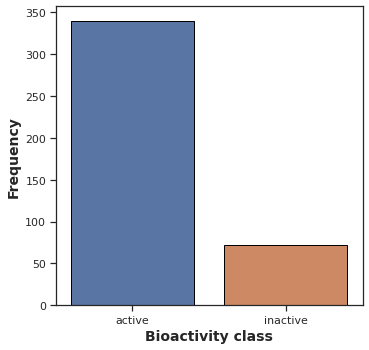

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

Scatter plot of MW versus LogP It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

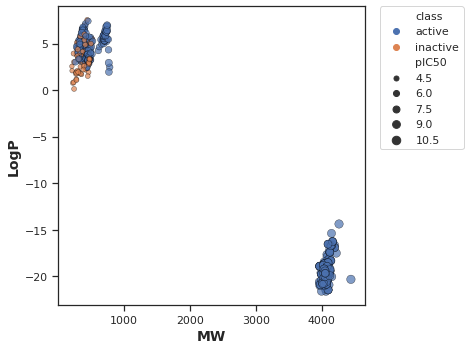

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

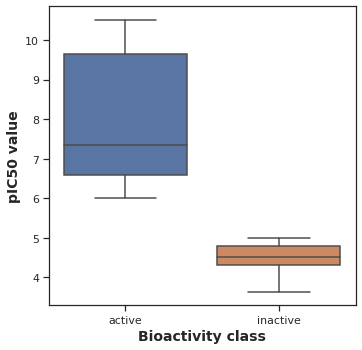

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

## Statistical analysis | Mann-Whitney U Test

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.00,0.00,0.05,Different distribution (reject H0)


## MW

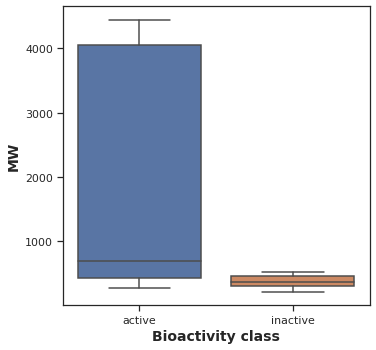

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,4180.00,0.00,0.05,Different distribution (reject H0)


## LogP

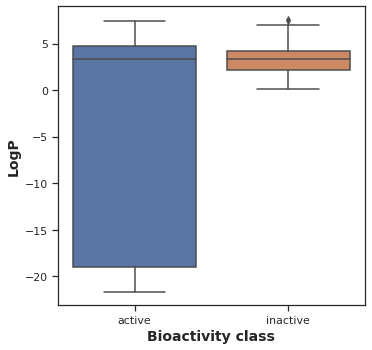

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')


Statistical analysis | Mann-Whitney U Test

In [ ]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,10665.50,0.04,0.05,Different distribution (reject H0)


## NumHDonors


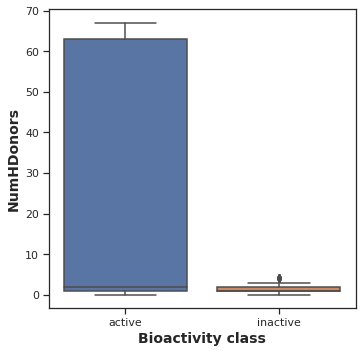

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,7925.50,0.00,0.05,Different distribution (reject H0)


### NumHAcceptors

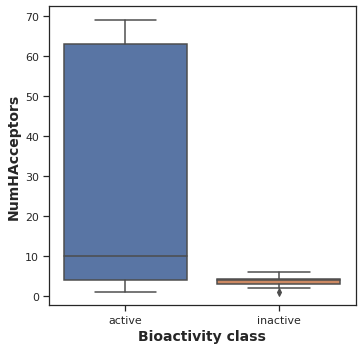

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,5183.00,0.00,0.05,Different distribution (reject H0)


# Interpretation of Statistical Results
*Box* *Plots*
*pIC50 values*
Taking a look at pIC50 values, the actives and inactives displayed statistically significant difference, which is to be expected since ***threshold values (IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives, corresponding to pIC50 > 6 = Actives and pIC50 < 5 = Inactives)*** were used to define actives and inactives.

Lipinski's descriptors
All of the 4 Lipinski's descriptors exhibited statistically significant difference between the actives and inactives.

In [ ]:
! zip -r results.zip . -i *.csv *.pdf

  adding: KV1.3_02_bioactivity_data_preprocessed.csv (deflated 94%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 11%)
  adding: plot_NumHAcceptors.pdf (deflated 37%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 10%)
  adding: KV1.3_03_bioactivity_data_curated.csv (deflated 94%)
  adding: plot_LogP.pdf (deflated 39%)
  adding: plot_ic50.pdf (deflated 36%)
  adding: plot_MW.pdf (deflated 40%)
  adding: KV1.3_01_bioactivity_data_raw.csv (deflated 95%)
  adding: KV1.3_04_bioactivity_data_3class_pIC50.csv (deflated 89%)
  adding: mannwhitneyu_MW.csv (deflated 8%)
  adding: mannwhitneyu_pIC50.csv (deflated 10%)
  adding: plot_bioactivity_class.pdf (deflated 38%)
  adding: plot_NumHDonors.pdf (deflated 37%)
  adding: mannwhitneyu_LogP.csv (deflated 10%)
  adding: plot_MW_vs_LogP.pdf (deflated 7%)


## Now  we will be calculating molecular descriptors that are essentially quantitative description of the compounds in the dataset.

In [ ]:
df3 = pd.read_csv('KV1.3_04_bioactivity_data_3class_pIC50.csv')

In [ ]:
df3

,Unnamed: 0,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,0,CHEMBL421891,CCCNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(Cl)cc1,intermediate,393.89,6.46,1.00,1.00,5.01
1,1,CHEMBL111539,CCCCNC(=O)c1cc(/C=C/c2ccccc2F)ccc1-c1ccc(Cl)cc1,intermediate,407.92,6.85,1.00,1.00,5.10
2,2,CHEMBL109336,CC(C)NC(=O)c1cc(/C=C/c2ccc(Cl)c(F)c2)ccc1-c1cc...,intermediate,428.33,7.11,1.00,1.00,5.43
3,3,CHEMBL418444,CCNC(=O)c1cc(/C=C/CCc2ccccc2)ccc1-c1ccc(Cl)cc1,intermediate,389.93,6.40,1.00,1.00,5.49
4,4,CHEMBL109739,N=C(N)NNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(...,intermediate,408.86,4.44,4.00,2.00,5.41
...,...,...,...,...,...,...,...,...,...
506,506,CHEMBL4208681,Nc1nc(/C=C/CNC(=O)C2CCNCC2)c[nH]1,inactive,249.32,0.12,4.00,4.00,4.52
507,507,CHEMBL4207090,Nc1nc(CCCNC(=O)c2cc(Br)c(Br)[nH]2)c[nH]1,inactive,391.07,2.21,4.00,3.00,4.52
508,508,CHEMBL4218820,Nc1nc(CCCNC(=O)c2cc3ccccc3[nH]2)c[nH]1,inactive,283.33,1.84,4.00,3.00,4.52
509,509,CHEMBL4211453,Nc1nc(CCCNC(=O)C2Cc3ccccc3N2)c[nH]1,inactive,285.35,1.08,4.00,4.00,4.52


In [ ]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df3[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
! cat molecule.smi | head -5

CCCNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(Cl)cc1	CHEMBL421891
CCCCNC(=O)c1cc(/C=C/c2ccccc2F)ccc1-c1ccc(Cl)cc1	CHEMBL111539
CC(C)NC(=O)c1cc(/C=C/c2ccc(Cl)c(F)c2)ccc1-c1ccc(Cl)cc1	CHEMBL109336
CCNC(=O)c1cc(/C=C/CCc2ccccc2)ccc1-c1ccc(Cl)cc1	CHEMBL418444
N=C(N)NNC(=O)c1cc(/C=C/c2ccc(F)cc2)ccc1-c1ccc(Cl)cc1	CHEMBL109739


In [ ]:
! cat molecule.smi | wc -l

511


# Calculate fingerprint descriptors

## Calculate PaDEL descriptors

In [ ]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

In [ ]:
! unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

In [ ]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [ ]:
! bash padel.sh

Processing CHEMBL421891 in molecule.smi (1/511). 
Processing CHEMBL111539 in molecule.smi (2/511). 
Processing CHEMBL109336 in molecule.smi (3/511). Average speed: 13.39 s/mol.
Processing CHEMBL418444 in molecule.smi (4/511). Average speed: 6.87 s/mol.
Processing CHEMBL109739 in molecule.smi (5/511). Average speed: 5.01 s/mol.
Processing CHEMBL109643 in molecule.smi (6/511). Average speed: 3.88 s/mol.
Processing CHEMBL281622 in molecule.smi (7/511). Average speed: 3.26 s/mol.
Processing CHEMBL112516 in molecule.smi (9/511). Average speed: 2.42 s/mol.
Processing CHEMBL111753 in molecule.smi (8/511). Average speed: 2.80 s/mol.
Processing CHEMBL325794 in molecule.smi (10/511). Average speed: 2.24 s/mol.
Processing CHEMBL112852 in molecule.smi (12/511). Average speed: 1.88 s/mol.
Processing CHEMBL110004 in molecule.smi (11/511). Average speed: 2.09 s/mol.
Processing CHEMBL109698 in molecule.smi (13/511). Average speed: 1.78 s/mol.
Processing CHEMBL55142 in molecule.smi (15/511). Average sp

In [ ]:
! ls -l

total 27844
-rw-r--r-- 1 root root   919613 Nov 28 14:48 descriptors_output.csv
-rw-r--r-- 1 root root   785361 Nov 28 14:11 KV1.3_01_bioactivity_data_raw.csv
-rw-r--r-- 1 root root   128331 Nov 28 14:14 KV1.3_02_bioactivity_data_preprocessed.csv
-rw-r--r-- 1 root root   132888 Nov 28 14:16 KV1.3_03_bioactivity_data_curated.csv
-rw-r--r-- 1 root root   163201 Nov 28 14:22 KV1.3_04_bioactivity_data_3class_pIC50.csv
-rw-r--r-- 1 root root    52797 Nov 28 14:16 KV1_3.zip
drwxr-xr-x 3 root root     4096 Nov 28 14:36 __MACOSX
-rw-r--r-- 1 root root      121 Nov 28 14:26 mannwhitneyu_LogP.csv
-rw-r--r-- 1 root root      120 Nov 28 14:25 mannwhitneyu_MW.csv
-rw-r--r-- 1 root root      132 Nov 28 14:27 mannwhitneyu_NumHAcceptors.csv
-rw-r--r-- 1 root root      128 Nov 28 14:27 mannwhitneyu_NumHDonors.csv
-rw-r--r-- 1 root root      120 Nov 28 14:25 mannwhitneyu_pIC50.csv
-rw-r--r-- 1 root root   125024 Nov 28 14:28 molecule.smi
drwxrwxr-x 4 root root     4096 May 30  2020 PaDEL-Descriptor
-rw-

# Preparing the X and Y Data Matrices X data matrix

In [ ]:
df3_X = pd.read_csv('descriptors_output.csv')

In [ ]:
df3_X = df3_X.drop(columns=['Name'])
df3_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
507,1,1,1,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
508,1,1,1,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
509,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Y** variable
Convert IC50 to pIC50

In [ ]:
df3_Y = df3['pIC50']
df3_Y

0     5.01
1     5.10
2     5.43
3     5.49
4     5.41
      ... 
506   4.52
507   4.52
508   4.52
509   4.52
510   4.52
Name: pIC50, Length: 511, dtype: float64

Combining X and Y variable


In [ ]:
dataset3 = pd.concat([df3_X,df3_Y], axis=1)
dataset3

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.01
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.10
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.43
3,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.49
4,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.52
507,1,1,1,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.52
508,1,1,1,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.52
509,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.52


In [ ]:
dataset3.to_csv('KV1.3_06_bioactivity_data_3class_pIC50_pubchem_fp.csv', index=False)


In [ ]:
# ?input features Fingureprints
X = dataset3.drop('pIC50', axis=1)
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
507,1,1,1,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
508,1,1,1,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
509,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Out put
Y = dataset3.pIC50
Y

0     5.01
1     5.10
2     5.43
3     5.49
4     5.41
      ... 
506   4.52
507   4.52
508   4.52
509   4.52
510   4.52
Name: pIC50, Length: 511, dtype: float64

In [ ]:
#  dimension
X.shape

(511, 881)

In [ ]:
Y.shape

(511,)

 Remove **low** variance features

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [ ]:
X.shape

(511, 199)

Data split (80:20 )

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.2,random_state=2)


In [ ]:
X_test.shape

(103, 199)

In [ ]:
X_train.shape, Y_train.shape

((408, 199), (408,))

 Building a Regression Model using Random Forest

In [ ]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.8901612408970097

In [ ]:
Y_pred = model.predict(X_test)

<function matplotlib.pyplot.show>

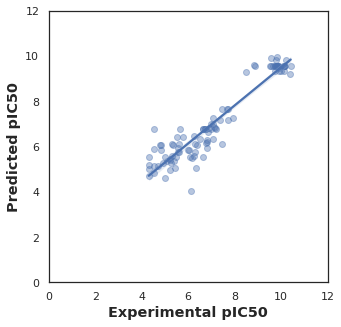

In [ ]:
sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

*Compare* ML algorithms

In [ ]:
X_train.shape

(408, 199)

In [ ]:
X_test.shape

(103, 199)

In [ ]:
Y_train

37    7.49
508   4.52
2     5.43
25    7.12
462   9.37
      ... 
22    6.51
72    6.49
493   4.52
15    6.33
168   5.13
Name: pIC50, Length: 408, dtype: float64

In [ ]:
# Defines and builds the lazyclassifier
clf1 = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
clf2 = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)

models_train,predictions_train = clf1.fit(X_train, X_train, Y_train, Y_train)

models_test,predictions_test = clf2.fit(X_train, X_test, Y_train, Y_test)

100%|██████████| 42/42 [00:15<00:00,  2.77it/s]


In [ ]:
# Performance table of the training set (80% subset)
predictions_train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DecisionTreeRegressor,0.88,0.94,0.46,0.04
ExtraTreeRegressor,0.88,0.94,0.46,0.06
ExtraTreesRegressor,0.88,0.94,0.46,0.73
GaussianProcessRegressor,0.88,0.94,0.46,0.11
XGBRegressor,0.88,0.94,0.46,0.41
RandomForestRegressor,0.85,0.92,0.50,0.68
BaggingRegressor,0.84,0.92,0.52,0.11
GradientBoostingRegressor,0.80,0.90,0.58,0.30
LGBMRegressor,0.80,0.90,0.58,0.11


In [ ]:
# Performance table of the test set (20% subset)
predictions_test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,43980994979215600764846379950852276224.00,-41825063852783459768635100251578957824.00,12559993534474213376.00,0.33
RANSACRegressor,133291859526565761122304.00,-126757944843890971377664.00,691446693453.27,1.59
TransformedTargetRegressor,2918564068211153174528.00,-2775497202122370842624.00,102315517792.86,0.04
LinearRegression,2918564068211153174528.00,-2775497202122370842624.00,102315517792.86,0.07
KernelRidge,14.91,-12.22,7.06,0.06
GaussianProcessRegressor,5.11,-2.91,3.84,0.09
LassoLars,2.06,-0.01,1.95,0.07
DummyRegressor,2.06,-0.01,1.95,0.03
Lasso,1.57,0.45,1.43,0.03


# Data visualization of model performance

[(0.0, 1.0)]

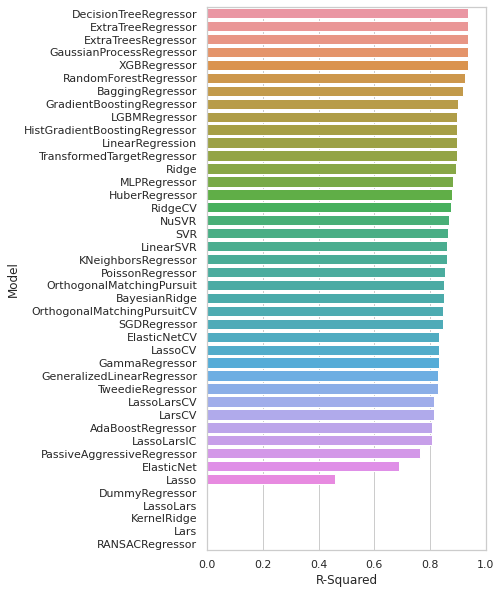

In [ ]:
# Bar plot of R-squared values
import matplotlib.pyplot as plt
import seaborn as sns

#train["R-Squared"] = [0 if i < 0 else i for i in train.iloc[:,0] ]

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_train)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

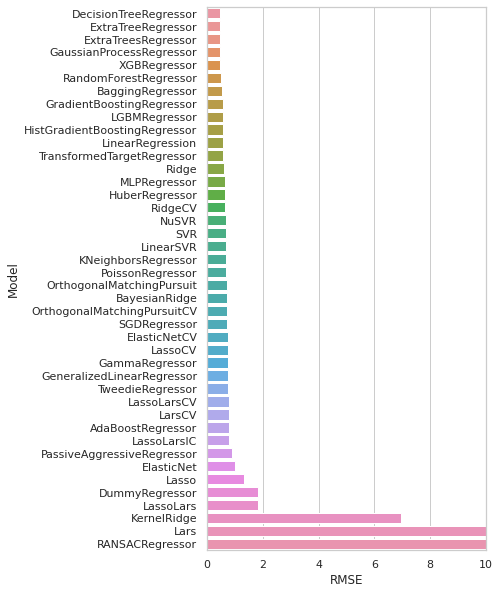

In [ ]:
# Bar plot of RMSE values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_train)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

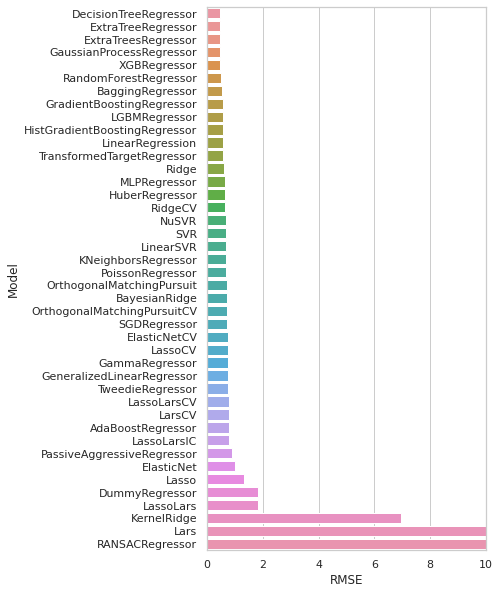

In [ ]:
# Bar plot of RMSE values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_train)
ax.set(xlim=(0, 10))